In [1]:
from random import choice
from IPython.display import Image
import random
random.seed(42)

## basics

In [2]:
Image(url='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*cHoY3vvKlW3sszxBmkABsA.png', width=500)

- training/构建mcts的统计树（statistical tree）的 select（节点选择，或者 traversal） 阶段
    - 用到的是 ucb 
- 但在 inference 阶段，也即选择最佳节点时，则是使用的 $\bar x_i$（即 ucb 公式左边的部分）

## random Binary Tree

In [3]:
class Node:
    def __init__(self, node_id=None):
        self.left = None
        self.right = None
        self.node_id = node_id
        self.value = None

    def __repr__(self):
        return "node@" + str(self.node_id)

    def __str__(self):
        return "node@" + str(self.node_id)

    def is_terminal(self):
        return self.left is None and self.right is None
           
    def find_children(self):
        if self.is_terminal():
            return {}
        return {self.left, self.right}

    def find_children_list(self):
        """This makes sure left, right order instead of an unsorted set"""
        if self.is_terminal():
            return []
        return [self.left, self.right]

    def find_random_child(self):
        if self.is_terminal():
            return None
        if choice([0, 1]) == 0:
            return self.left
        else:
            return self.right

    def reward(self):
        return self.value

In [4]:
def make_binary_tree(depth=12):
    all_nodes = []
    for i in range(depth + 1):
        nodes_at_depth = []
        num_of_nodes = pow(2, i)
        for j in range(num_of_nodes):
            nodes_at_depth.append(Node(str(i) + "_" + str(j)))
        all_nodes.append(nodes_at_depth)

    leaf_nodes_dict = dict()
    for level, nodes in enumerate(all_nodes):
        for loc, n in enumerate(nodes):
            if level >= len(all_nodes) - 1:
                # we assign reward value to leaf nodes of the tree
                n.value = random.uniform(0, 100)
                leaf_nodes_dict[n] = n.value
            else:
                left = all_nodes[level + 1][2 * loc]
                right = all_nodes[level + 1][2 * loc + 1]
                n.left = left
                n.right = right
    root = all_nodes[0][0]
    return root, leaf_nodes_dict

In [6]:
root, leaf_nodes_dict = make_binary_tree(depth=3)

In [8]:
leaf_nodes_dict

{node@3_0: 51.58136315528283,
 node@3_1: 23.16709728180616,
 node@3_2: 16.948289181310216,
 node@3_3: 3.606113314434878,
 node@3_4: 23.925662528737725,
 node@3_5: 0.028727185462340543,
 node@3_6: 15.744476085039082,
 node@3_7: 99.68171438272063}

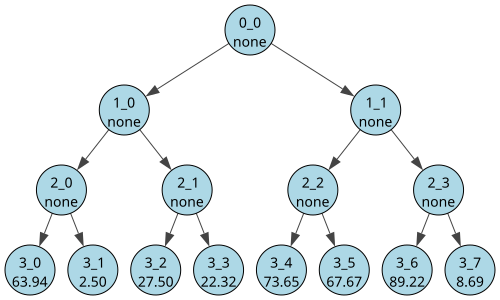

In [7]:
import igraph as ig
g = ig.Graph(directed=True)

# 用于跟踪已添加节点的字典
nodes_dict = {}

def add_nodes_and_edges(node, parent_id=None):
    # 添加当前节点（如果尚未添加）
    if node not in nodes_dict:
        nodes_dict[node.node_id] = (len(nodes_dict), f'{node.value:.2f}' if node.value else 'none')
        g.add_vertices(1)
    
    current_id = nodes_dict[node.node_id][0]
    
    # 添加从父节点到当前节点的边
    if parent_id is not None:
        g.add_edges([(parent_id, current_id)])
    
    # 递归为子节点做同样的处理
    # for child in node.children.values():
    if node.left:
        add_nodes_and_edges(node.left, current_id)
    if node.right:
        add_nodes_and_edges(node.right, current_id)

# 从根节点开始添加节点和边
add_nodes_and_edges(root)
layout = g.layout("tree", root=[0])

g.vs["size"] = 50  # 你可以根据需要调整大小
g.vs["color"] = "lightblue"  # 或者使用颜色列表来为每个节点指定不同的颜色
# 设置节点名称
g.vs["label"] = [f'{node_id}\n{nodes_dict[node_id][1]}' for node_id in nodes_dict]

# 可视化
ig.plot(g, layout=layout, bbox=(500, 300), margin=30)

## MCTS

In [8]:
from collections import defaultdict
import math


class MCTS:
    "Monte Carlo tree searcher. First rollout the tree then choose a move."

    def __init__(self, exploration_weight=1.0):
        self.Q = defaultdict(float)  # total reward of each node
        self.N = defaultdict(float)  # total visit count for each node
        self.children = dict()  # children of each node: key is explored node, value is set of children
        self.exploration_weight = exploration_weight

    def choose(self, node):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(self.children[node], key=score)

    def run(self, node, num_rollout):
        "Run on iteration of select -> expand -> simulation(rollout) -> backup"
        path = self.select(node)
        leaf = path[-1]
        self.expand(leaf)
        reward = 0
        for i in range(num_rollout):
            reward += self.simulate(leaf)
        self.backup(path, reward)

    def select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  # descend a layer deeper

    def expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        self.children[node] = node.find_children()

    def simulate(self, node):
        "Run a random simulation from node as starting point"
        while True:
            if node.is_terminal():
                return node.reward()
            node = node.find_random_child()

    def backup(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward

    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"

        # All children of node should already be expanded:
        # a node is fully expanded if and only if all children are explored
        is_all_children_expanded = all(n in self.children for n in self.children[node])
        if not is_all_children_expanded:
            raise ValueError("Can only select fom fully expanded node")

        log_N_parent = math.log(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(
                log_N_parent / self.N[n]
            )

        return max(self.children[node], key=uct)

## MCTS playout

In [10]:
def mcts_playout(depth, num_iter, num_rollout, exploration_weight):
    root, leaf_nodes_dict = make_binary_tree(depth=depth)
    leaf_nodes_dict_sorted = sorted(leaf_nodes_dict.items(), key=lambda x: x[1], reverse=True)
    print("Expected (max) leaf node: {}, value: {}".format(leaf_nodes_dict_sorted[0][0],
                                                           leaf_nodes_dict_sorted[0][1]))
    print("Expected (min) leaf node: {}, value: {}".format(leaf_nodes_dict_sorted[-1][0],
                                                           leaf_nodes_dict_sorted[-1][1]))

    mcts = MCTS(exploration_weight=exploration_weight)
    while True:
        # we run MCTS simulation for many times
        for _ in range(num_iter):
            mcts.run(root, num_rollout=num_rollout)
        # we choose the best greedy action based on simulation results
        root = mcts.choose(root)
        # we repeat until root is terminal
        if root.is_terminal():
            print("Found optimal (max) leaf node: {}, value: {}".format(root, root.value))
            return root.value

In [12]:
mcts_playout(depth=12, 
             num_iter=50, 
             num_rollout=1, 
             exploration_weight=51)

Expected (max) leaf node: node@12_3928, value: 99.94451352598055
Expected (min) leaf node: node@12_246, value: 0.009234639492805563
Found optimal (max) leaf node: node@12_4091, value: 99.03142999731537


99.03142999731537